In [ ]:
# =========================
# ETAPE 1 — Chargement NAB
# =========================
import pandas as pd, numpy as np, requests
from sklearn.preprocessing import StandardScaler

category = "realTweets"
fname    = "Twitter_volume_AMZN.csv"

# 1) Charger la série depuis GitHub
raw_csv = f"https://raw.githubusercontent.com/numenta/NAB/master/data/{category}/{fname}"
df = pd.read_csv(raw_csv)

# Détecter les colonnes temps / valeur
time_candidates  = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if not time_candidates:
    raise ValueError("Impossible de trouver la colonne temps (contient 'time' ou 'date').")
TIME_COL = time_candidates[0]
value_candidates = [c for c in df.columns if c != TIME_COL and df[c].dtype != "object"]
if not value_candidates:

    for c in df.columns:
        if c != TIME_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().any():
                value_candidates = [c]; break
if not value_candidates:
    raise ValueError("Impossible de trouver la colonne valeur.")
VALUE_COL = value_candidates[0]

# Nettoyage + tri temporel
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df[[TIME_COL, VALUE_COL]].dropna().sort_values(TIME_COL).reset_index(drop=True)

# 2) Charger les fenêtres d'anomalies
labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
windows = requests.get(labels_url).json()
key = f"{category}/{fname}"
win_list = windows.get(key, [])

# 3) Créer les labels point-par-point
ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)

for w in win_list:
    if isinstance(w, dict):
        s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
    elif isinstance(w, (list, tuple)) and len(w) >= 2:
        s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
    else:
        continue
    labels_points |= (ts >= s) & (ts <= e)

df["label"] = labels_points.astype(int)

# 4) Standardiser uniquement sur le normal
scaler = StandardScaler().fit(df.loc[df["label"]==0, [VALUE_COL]])
df["x"] = scaler.transform(df[[VALUE_COL]])

n_total = len(df)
n_anom  = int(df["label"].sum())
print(f"Série chargée: {key}")
print(f"Période: {df[TIME_COL].min()} -> {df[TIME_COL].max()} | n={n_total}")
print(f"Fenêtres NAB: {len(win_list)} | Points anormaux (NAB): {n_anom}")
display(df.head())

Série chargée: realTweets/Twitter_volume_AMZN.csv
Période: 2015-02-26 21:42:53 -> 2015-04-22 20:52:53 | n=15831
Fenêtres NAB: 4 | Points anormaux (NAB): 1580


,timestamp,value,label,x
0,2015-02-26 21:42:53,57,0,0.194765
1,2015-02-26 21:47:53,43,0,-0.370686
2,2015-02-26 21:52:53,55,0,0.113986
3,2015-02-26 21:57:53,64,0,0.477491
4,2015-02-26 22:02:53,93,0,1.648783


In [ ]:
ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)

def mark_interval(s, e):
    s = pd.to_datetime(s); e = pd.to_datetime(e)
    return (ts >= s) & (ts <= e)

for w in win_list:

    if isinstance(w, dict) and "start" in w and "end" in w:
        labels_points |= mark_interval(w["start"], w["end"])


    elif isinstance(w, (list, tuple)) and len(w) >= 2 and isinstance(w[0], (str, pd.Timestamp)):
        labels_points |= mark_interval(w[0], w[1])


    elif isinstance(w, (list, tuple)) and len(w) >= 1:
        for ww in w:
            if isinstance(ww, dict) and "start" in ww and "end" in ww:
                labels_points |= mark_interval(ww["start"], ww["end"])
            elif isinstance(ww, (list, tuple)) and len(ww) >= 2:
                labels_points |= mark_interval(ww[0], ww[1])


    else:
        pass

df["label"] = labels_points.astype(int)

In [ ]:
print("Nombre d'anomalies :", len(win_list))
for i, (start, end) in enumerate(win_list, 1):
    print(f"Anomalie {i} : {start}  ->  {end}")

Nombre d'anomalies : 4
Anomalie 1 : 2015-03-05 03:22:53.000000  ->  2015-03-06 12:12:53.000000
Anomalie 2 : 2015-03-11 04:32:53.000000  ->  2015-03-12 13:22:53.000000
Anomalie 3 : 2015-04-01 05:32:53.000000  ->  2015-04-02 14:22:53.000000
Anomalie 4 : 2015-04-07 12:27:53.000000  ->  2015-04-08 21:17:53.000000


In [ ]:
# =========================
# ETAPE 2 Fenêtrage + masques
# =========================
import numpy as np
import pandas as pd


SEQ_LEN = 15

def to_windows(series: pd.Series, seq_len: int):
    X = []
    for i in range(len(series) - seq_len):
        X.append(series.iloc[i:i+seq_len].values.reshape(seq_len, 1))
    return np.array(X, dtype=np.float32)

# 1) Fenêtres sur la série standardisée
X_all = to_windows(df["x"], SEQ_LEN)
dates_all = df[TIME_COL].iloc[SEQ_LEN:].reset_index(drop=True)

# 3) Marquer si une fenêtre touche une anomalie
labels_points = df["label"].astype(bool).to_numpy()
win_is_anom = np.array([
    labels_points[i:i+SEQ_LEN].any()
    for i in range(len(labels_points) - SEQ_LEN)
], dtype=bool)

# 4) Masques
idx_norm = ~win_is_anom
X_train  = X_all[idx_norm]
n_all, n_norm, n_anom = len(X_all), int(idx_norm.sum()), int((~idx_norm).sum())

print(f"Fenêtres totales : {n_all}")
print(f"   ↳ 100% normales (train) : {n_norm}")
print(f"   ↳ touchent une anomalie : {n_anom}")

print("\nVérifs de shapes :")
print("X_all :", X_all.shape, "| X_train :", X_train.shape, "| dates_all :", dates_all.shape)
assert len(X_all) == len(dates_all) == len(win_is_anom), "Incohérence tailles fenêtres/dates/labels."
assert n_norm > 0, "Aucune fenêtre 100% normale pour entraîner l'AE — augmente SEQ_LEN ou vérifie les labels."

Fenêtres totales : 15816
   ↳ 100% normales (train) : 14180
   ↳ touchent une anomalie : 1636

Vérifs de shapes :
X_all : (15816, 15, 1) | X_train : (14180, 15, 1) | dates_all : (15816,)


In [ ]:
# =========================
# ETAPE 3  LSTM + Autoencodeur
# =========================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras import regularizers

latent_dim = 64
reg_l2 = 1e-5
drop = 0.3

# --- Encodeur ---
inputs = Input(shape=(SEQ_LEN, 1))
encoded = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(reg_l2))(inputs)
encoded = Dropout(drop)(encoded)
encoded = LSTM(latent_dim, return_sequences=False, kernel_regularizer=regularizers.l2(reg_l2))(encoded)

# --- Bottleneck ---
bottleneck = RepeatVector(SEQ_LEN)(encoded)

# --- Décodeur ---
decoded = LSTM(latent_dim, return_sequences=True, kernel_regularizer=regularizers.l2(reg_l2))(bottleneck)
decoded = Dropout(drop)(decoded)
decoded = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(reg_l2))(decoded)
outputs = TimeDistributed(Dense(1))(decoded)

# --- Modèle complet ---
model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

Entraînement sur 12762 fenêtres, validation sur 1418.
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.4791 - val_loss: 0.3425
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - loss: 0.3774 - val_loss: 0.3174
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - loss: 0.3547 - val_loss: 0.3064
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - loss: 0.3380 - val_loss: 0.2975
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 0.3288 - val_loss: 0.2906
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - loss: 0.3203 - val_loss: 0.2877
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - loss: 0.3172 - val_loss: 0.2801
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.3055 - val_loss: 0.2723
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - loss: 0.3020 - val_loss: 0.2683
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 0.2965 - val_loss: 0.2647
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - 

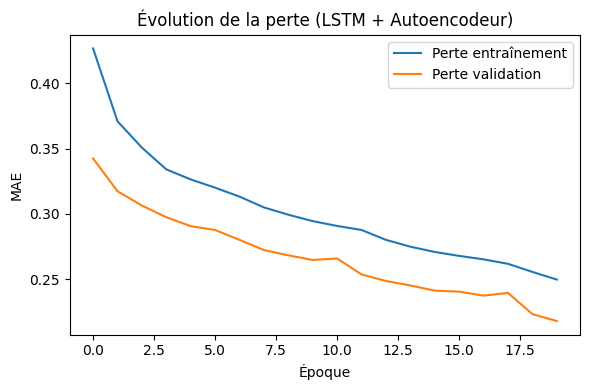

In [ ]:
# =========================
# ETAPE 4 — Entraînement LSTM + AE
# =========================
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# On garde les 10 % dernières fenêtres normales pour validation temporelle
val_split = 0.1
n_val = int(len(X_train) * val_split)
X_train_sub = X_train[:-n_val]
X_val_sub   = X_train[-n_val:]

print(f"Entraînement sur {len(X_train_sub)} fenêtres, validation sur {len(X_val_sub)}.")

history = model.fit(
    X_train_sub, X_train_sub,
    epochs=20,
    batch_size=64,
    suffle=False,
    validation_data=(X_val_sub, X_val_sub),
    callbacks=[es],
    verbose=1
)

# --- Courbe de perte ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Perte entraînement")
plt.plot(history.history["val_loss"], label="Perte validation")
plt.xlabel("Époque")
plt.ylabel("MAE")
plt.legend()
plt.title("Évolution de la perte (LSTM + Autoencodeur)")
plt.tight_layout()
plt.show()

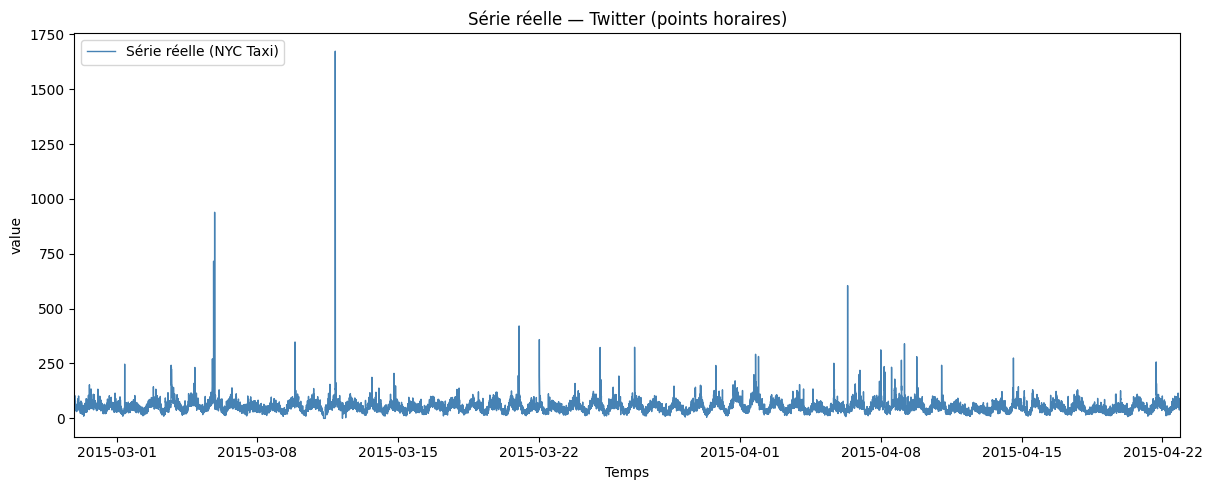

In [ ]:
# ===============================
# VISUALISATION
# ===============================
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,5))
plt.plot(df[TIME_COL], df[VALUE_COL], lw=1, color="steelblue", label="Série réelle (TWITTER)")
plt.title("Série réelle — Twitter (points horaires)")
plt.xlabel("Temps")
plt.ylabel(VALUE_COL)
plt.legend(loc="upper left")
plt.tight_layout()

# Verrouiller les limites de l'axe X exactement à la période du dataset
plt.xlim(df[TIME_COL].min(), df[TIME_COL].max())

plt.show()

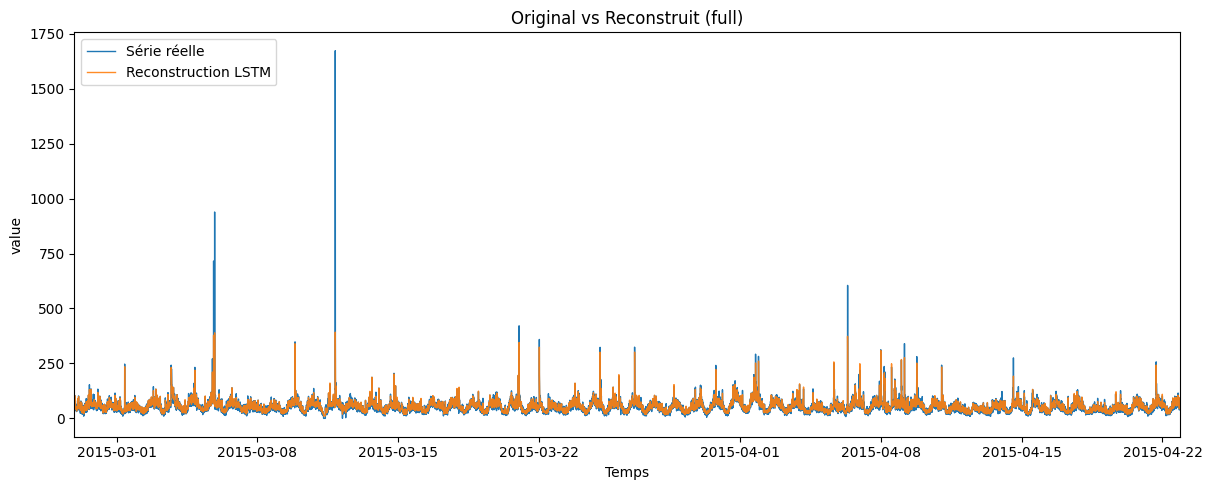

In [ ]:
# ===============================
# Reconstruction
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prédire toutes les fenêtres
pred_all = model.predict(X_all, verbose=0)
pred_all = pred_all.squeeze(-1)

# 2) Recoller les fenêtres
n = len(df)
recon_sum   = np.zeros(n, dtype=float)
recon_count = np.zeros(n, dtype=float)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

valid_mask = recon_count > 0
recon = np.zeros(n, dtype=float)
recon[valid_mask] = recon_sum[valid_mask] / recon_count[valid_mask]

# 3) Ramener à l’échelle d’origine
try:
    recon_value    = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    original_value = df[VALUE_COL].to_numpy()
except Exception:
    recon_value    = recon
    original_value = df.get("x", df[VALUE_COL]).to_numpy()

# 4) Tracer
def plot_reconstruction(start=None, end=None, title_suffix="(full)"):
    ts = df[TIME_COL]
    mask = np.ones(len(df), dtype=bool)
    if start is not None: mask &= (ts >= pd.to_datetime(start))
    if end   is not None: mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    plt.plot(ts[mask], original_value[mask], lw=1, label="Série réelle")
    plt.plot(ts[mask & valid_mask], recon_value[mask & valid_mask], lw=1, alpha=0.9, label="Reconstruction LSTM")
    plt.title(f"Original vs Reconstruit {title_suffix}")
    plt.xlabel("Temps"); plt.ylabel(VALUE_COL)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim(ts.min(), ts.max())
    plt.show()

plot_reconstruction()

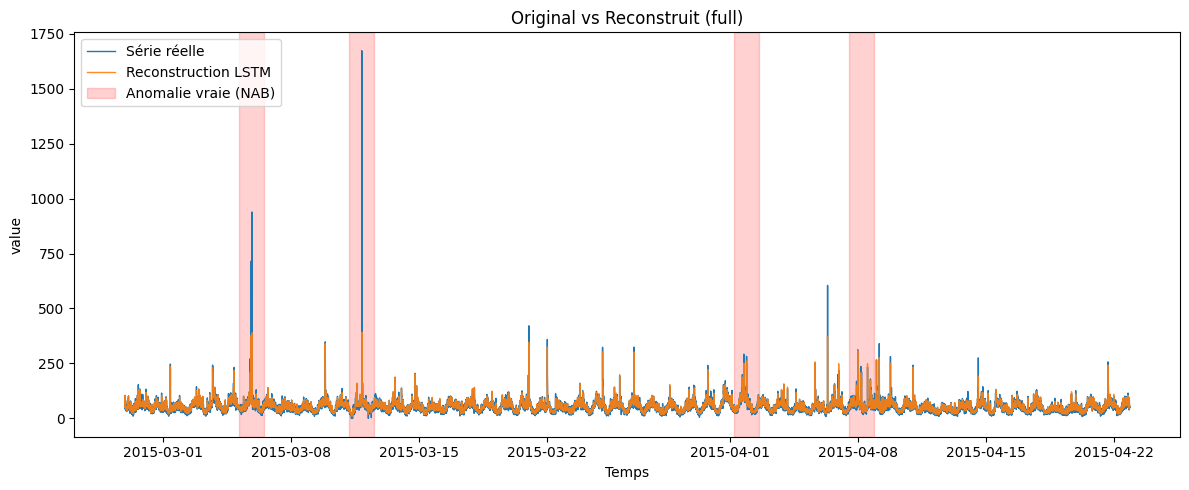

In [ ]:
# ===============================
# Reconstruction
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prédire toutes les fenêtres
pred_all = model.predict(X_all, verbose=0)
pred_all = pred_all.squeeze(-1)

# 2) Recoller les fenêtres en moyenne sur les recouvrements

n = len(df)
recon_sum   = np.zeros(n, dtype=float)
recon_count = np.zeros(n, dtype=float)

for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

# Évite la zone initiale
valid_mask = recon_count > 0
recon = np.zeros(n, dtype=float)
recon[valid_mask] = recon_sum[valid_mask] / recon_count[valid_mask]

# 3) Ramener à l’échelle d’origine
try:

    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    original_value = df[VALUE_COL].to_numpy()
except Exception:

    recon_value = recon
    original_value = df.get("x", df[VALUE_COL]).to_numpy()

true_intervals = []
labels = df["label"].to_numpy(dtype=int)
ts = df[TIME_COL].to_numpy()
if labels.sum() > 0:
    in_run = False
    start_idx = None
    for i, lab in enumerate(labels):
        if lab == 1 and not in_run:
            in_run = True
            start_idx = i
        if lab == 0 and in_run:
            in_run = False
            true_intervals.append((pd.to_datetime(ts[start_idx]), pd.to_datetime(ts[i-1])))
    if in_run:
        true_intervals.append((pd.to_datetime(ts[start_idx]), pd.to_datetime(ts[len(labels)-1])))

# 4) Tracer
def plot_reconstruction(start=None, end=None, show_true=True, title_suffix="(full)"):
    ts = df[TIME_COL]
    base_mask = np.ones(len(df), dtype=bool)
    if start is not None:
        base_mask &= (ts >= pd.to_datetime(start))
    if end is not None:
        base_mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    # Série réelle sur tout le masque demandé
    plt.plot(ts[base_mask], original_value[base_mask], lw=1, label="Série réelle")
    # Reconstruction uniquement là où elle est définie
    mask_rec = base_mask & valid_mask
    plt.plot(ts[mask_rec], recon_value[mask_rec], lw=1, alpha=0.9, label="Reconstruction LSTM")

    # bandes anomalies vraies
    if show_true and len(true_intervals):
        once = True

        tmin, tmax = ts[base_mask].iloc[0], ts[base_mask].iloc[-1]
        for s,e in true_intervals:
            if (s <= tmax) and (e >= tmin):
                plt.axvspan(s, e, alpha=0.18, color="red",
                            label="Anomalie vraie (NAB)" if once else None)
                once = False

    plt.title(f"Original vs Reconstruit {title_suffix}")
    plt.xlabel("Temps"); plt.ylabel(VALUE_COL)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot_reconstruction()


In [ ]:
# =========================
# Reconstruction
# =========================
import numpy as np
import pandas as pd

# 1) Prédire toutes les fenêtres et recoller
pred_all = model.predict(X_all, verbose=0).squeeze(-1)
n = len(df)

recon_sum   = np.zeros(n)
recon_count = np.zeros(n)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask_valid = recon_count > 0
recon[mask_valid] = recon_sum[mask_valid] / recon_count[mask_valid]

# 2) Remettre la reconstruction à l’échelle d’origine
try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except Exception:

    recon_value = recon
    orig_value  = df["x"].to_numpy()

# 3) Erreur + lissage
df["recon"]      = recon_value
df["abs_err"]    = np.abs(orig_value - recon_value)
df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

WIN = 7
df["err_smooth"] = (
    df["abs_err"]
    .rolling(WIN, center=True, min_periods=1).median()
    .rolling(WIN, center=True, min_periods=1).mean()
)

valid_pts = df["err_smooth"].notna().sum()
print(f"Reconstruction OK. Points valides pour l'erreur lissée : {valid_pts}/{len(df)}")
display(df[[TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].head(10))

Reconstruction OK. Points valides pour l'erreur lissée : 15823/15831


,timestamp,value,recon,abs_err,err_smooth
0,2015-02-26 21:42:53,57,51.192650,NaN,NaN
1,2015-02-26 21:47:53,43,49.288012,NaN,NaN
2,2015-02-26 21:52:53,55,53.566110,NaN,NaN
3,2015-02-26 21:57:53,64,65.825311,NaN,NaN
4,2015-02-26 22:02:53,93,93.800626,NaN,NaN
5,2015-02-26 22:07:53,104,103.641640,NaN,NaN
6,2015-02-26 22:12:53,89,87.556592,NaN,NaN
7,2015-02-26 22:17:53,87,77.820524,NaN,NaN
8,2015-02-26 22:22:53,57,69.089692,NaN,1.896252
9,2015-02-26 22:27:53,68,65.713887,NaN,3.038682


In [ ]:
import requests, pandas as pd

def load_anomaly_windows_for(series_relpath: str):
    """
    Retourne [(start_ts, end_ts), ...] pour une série NAB donnée,
    en gérant les items au format dict {"start","end"} OU liste ["start","end"].
    """
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    windows = requests.get(labels_url).json()
    raw_list = windows.get(series_relpath, [])
    out = []
    for w in raw_list:
        if isinstance(w, dict) and "start" in w and "end" in w:
            s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
        elif isinstance(w, (list, tuple)) and len(w) >= 2:
            s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
        else:
            continue
        if e < s:
            s, e = e, s
        out.append((s, e))
    return out

In [ ]:
if 'thr' not in globals():
    normal_mask = (df['label'] == 0) & df['err_smooth'].notna()
    err_norm = df.loc[normal_mask, 'err_smooth'].values
    assert err_norm.size > 0, "Pas d'erreurs 'normales' disponibles pour fixer le seuil."
    thr = np.percentile(err_norm, 99.0)
    print(f"thr (p99 sur normal) = {thr:.6f}  [n={err_norm.size}]")

thr (p99 sur normal) = 10.538626  [n=14243]


Seuil adaptatif par heure (q=0.99)
Precision=0.671 | Recall=0.217 | F1=0.328


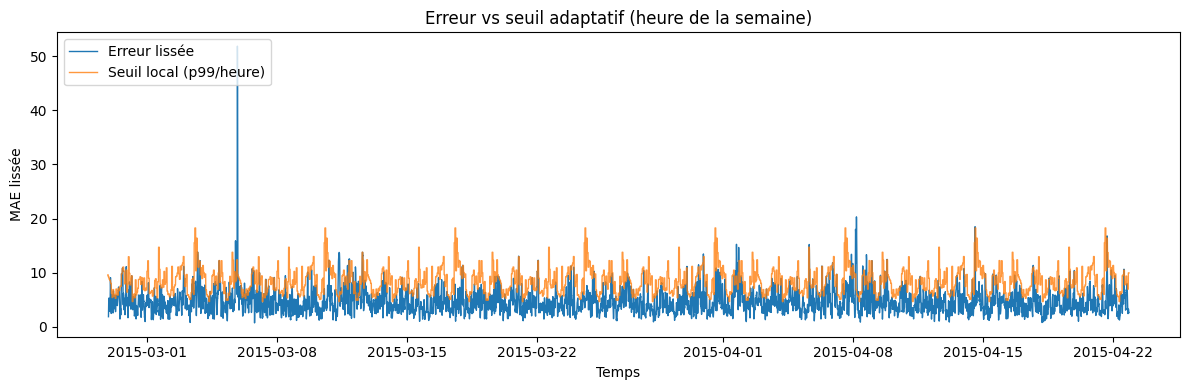

In [ ]:
df["hour_of_week"] = df[TIME_COL].dt.dayofweek * 24 + df[TIME_COL].dt.hour

valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask

# 1) Seuil local
q = 0.99
thr_map = (
    df.loc[normal_mask_points, ["hour_of_week", "err_smooth"]]
      .groupby("hour_of_week")["err_smooth"]
      .quantile(q)
)

# Appliquer le seuil correspondant à l'heure de chaque point
df["thr_local"] = df["hour_of_week"].map(thr_map).astype(float).values

# 2) Prédiction
err = df["err_smooth"].to_numpy()
thr_local = df["thr_local"].to_numpy()
pred = np.zeros(len(df), dtype=bool)
pred[valid_mask] = err[valid_mask] > thr_local[valid_mask]

df["pred_point"] = pred.astype(int)

# 3) Métriques
y_true = (df["label"].values == 1) & valid_mask
y_pred = pred & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))

precision = TP / (TP + FP + 1e-12)
recall    = TP / (TP + FN + 1e-12)
f1        = 2*precision*recall / (precision + recall + 1e-12)

print(f"Seuil adaptatif par heure (q={q})")
print(f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")
plt.plot(df[TIME_COL], df["thr_local"], lw=1, alpha=0.8, label="Seuil local (p99/heure)")
plt.title("Erreur vs seuil adaptatif (heure de la semaine)")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left"); plt.tight_layout(); plt.show()

🔍 Seuil de détection : erreur > 1.5 × seuil_local


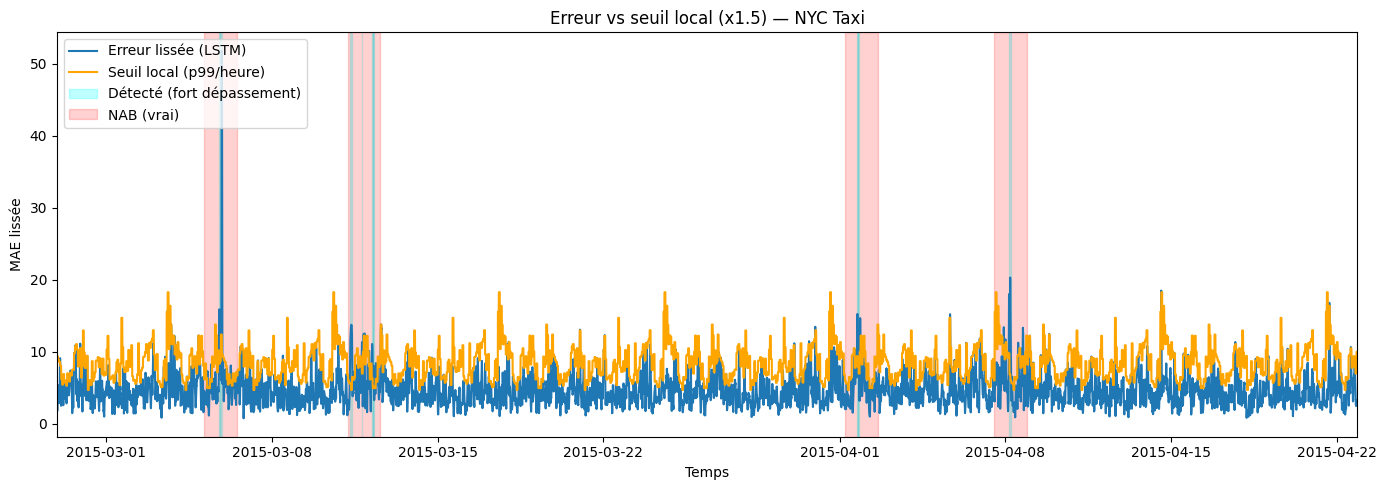


📊 Évaluation point-par-point :
- Vrais positifs (TP) : 93
- Faux positifs (FP) : 0
- Faux négatifs (FN) : 1487
- Vrais négatifs (TN) : 14251

✅ Precision = 1.000 | Recall = 0.059 | F1 = 0.111

Nb intervalles vrais (NAB) : 4
Nb intervalles détectés (pics forts) : 13

🕒 Intervalles détectés :
 - 2015-03-05 18:17:53 → 2015-03-05 18:47:53
 - 2015-03-05 19:32:53 → 2015-03-05 19:52:53
 - 2015-03-05 20:42:53 → 2015-03-05 21:32:53
 - 2015-03-11 07:07:53 → 2015-03-11 09:17:53
 - 2015-03-11 19:02:53 → 2015-03-11 19:27:53
 - 2015-03-12 05:22:53 → 2015-03-12 05:57:53
 - 2015-03-12 06:02:53 → 2015-03-12 06:07:53
 - 2015-03-12 06:52:53 → 2015-03-12 07:07:53
 - 2015-04-01 17:37:53 → 2015-04-01 17:57:53
 - 2015-04-01 18:02:53 → 2015-04-01 18:07:53
 - 2015-04-01 18:12:53 → 2015-04-01 18:17:53
 - 2015-04-01 19:02:53 → 2015-04-01 19:12:53
 - 2015-04-08 03:32:53 → 2015-04-08 05:27:53


In [ ]:
# ===============================
# Détection
# ===============================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

assert "err_smooth" in df.columns, "df['err_smooth'] manquant (Étape 5a)."
assert "thr_local" in df.columns, "df['thr_local'] manquant (calcul p99/heure)."

FACTOR = 1.5
print(f" Seuil de détection : erreur > {FACTOR} × seuil_local")

valid_mask = df["err_smooth"].notna().to_numpy()
pred = np.zeros(len(df), dtype=bool)
pred[valid_mask] = (
    df.loc[valid_mask, "err_smooth"].to_numpy()
    > FACTOR * df.loc[valid_mask, "thr_local"].to_numpy()
)

def flags_to_intervals(flags, dates):
    ints = []
    on = False; start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True; start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False; ints.append((start, dates.iloc[i]))
    if on:
        ints.append((start, dates.iloc[-1]))
    return ints

detected_ints = flags_to_intervals(pred, df[TIME_COL])
true_ints     = flags_to_intervals(df["label"].astype(bool).to_numpy(), df[TIME_COL])

# 3) Tracé
plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1.5, label="Erreur lissée (LSTM)")
plt.plot(df[TIME_COL], df["thr_local"],  lw=1.5, color="orange", label="Seuil local (p99/heure)")

lab_done = False
for s,e in detected_ints:
    plt.axvspan(s, e, color="cyan", alpha=0.25, label=None if lab_done else "Détecté (fort dépassement)")
    lab_done = True

lab_done = False
for s,e in true_ints:
    plt.axvspan(s, e, color="red", alpha=0.18, label=None if lab_done else "NAB (vrai)")
    lab_done = True

plt.title(f"Erreur vs seuil local (x{FACTOR}) — NYC Taxi")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.xlim(df[TIME_COL].min(), df[TIME_COL].max())
plt.tight_layout()
plt.show()

y_true = (df["label"].values == 1) & valid_mask
y_pred = pred & valid_mask

TP = int(np.sum(y_true & y_pred))
FP = int(np.sum(~y_true & y_pred))
FN = int(np.sum(y_true & ~y_pred))
TN = int(np.sum(~y_true & ~y_pred))

precision = TP / (TP + FP) if (TP + FP) else 0.0
recall    = TP / (TP + FN) if (TP + FN) else 0.0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

print("\n Évaluation point-par-point :")
print(f"- Vrais positifs (TP) : {TP}")
print(f"- Faux positifs (FP) : {FP}")
print(f"- Faux négatifs (FN) : {FN}")
print(f"- Vrais négatifs (TN) : {TN}")
print(f"\n Precision = {precision:.3f} | Recall = {recall:.3f} | F1 = {f1:.3f}")

print(f"\nNb intervalles vrais (NAB) : {len(true_ints)}")
print(f"Nb intervalles détectés (pics forts) : {len(detected_ints)}")
print("\n Intervalles détectés :")
for s,e in detected_ints:
    print(f" - {s} → {e}")

Seuil adaptatif par heure (q=0.999, FACTOR=1.09)
- TP=1260  FP=320  FN=320  TN=13931
Precision=0.797 | Recall=0.797 | F1=0.797


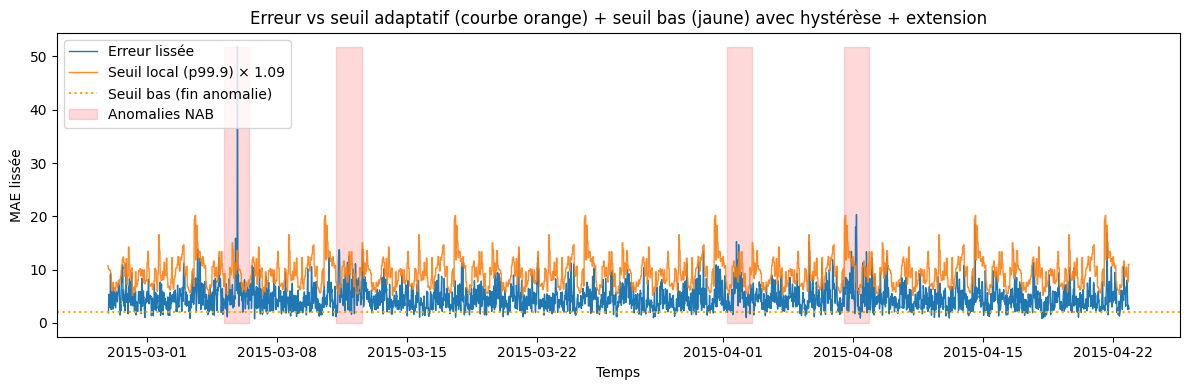

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df["hour_of_week"] = df[TIME_COL].dt.dayofweek * 24 + df[TIME_COL].dt.hour

valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask

q = 0.999
thr_map = (
    df.loc[normal_mask_points, ["hour_of_week", "err_smooth"]]
      .groupby("hour_of_week")["err_smooth"]
      .quantile(q)
)

df["thr_local"] = df["hour_of_week"].map(thr_map).astype(float).values

df["thr_local"] = df["thr_local"].rolling(3, center=True, min_periods=1).mean()

FACTOR = 1.09
thr_eff = FACTOR * df["thr_local"].to_numpy()

seuil_bas = np.nanmean(thr_eff) * 0.21

err = df["err_smooth"].to_numpy()

flags = np.zeros(len(df), dtype=bool)
en_anomalie = False

for i in range(len(df)):
    if not valid_mask[i]:
        continue

    if not en_anomalie:

        if err[i] > thr_eff[i]:
            en_anomalie = True
            flags[i] = True
    else:

        if err[i] > seuil_bas:
            flags[i] = True
        else:
            en_anomalie = False

L_before = 15
L_after  = 7

flags_ext = np.zeros_like(flags)
in_seg = False
start = None

for i in range(len(flags)):
    if flags[i] and not in_seg:
        in_seg = True
        start = i
    if (not flags[i] and in_seg) or (i == len(flags)-1 and in_seg):
        end = i if not flags[i] else i

        s_ext = max(0, start - L_before)
        e_ext = min(len(flags) - 1, end + L_after)
        flags_ext[s_ext:e_ext+1] = True
        in_seg = False

flags = flags_ext

df["pred_point"] = flags.astype(int)

# 3) Métriques
y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))

precision = TP / (TP + FP + 1e-12)
recall    = TP / (TP + FN + 1e-12)
f1        = 2 * precision * recall / (precision + recall + 1e-12)

print(f"Seuil adaptatif par heure (q={q}, FACTOR={FACTOR})")
print(f"- TP={TP}  FP={FP}  FN={FN}  TN={TN}")
print(f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

# 4) Graphique erreur
plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")

# courbe
plt.plot(
    df[TIME_COL],
    thr_eff,
    lw=1,
    alpha=0.9,
    label=f'Seuil local (p{int(q*1000)/10}) × {FACTOR}'
)

plt.axhline(
    y=seuil_bas,
    color="orange",
    linestyle=":",
    label="Seuil bas (fin anomalie)"
)

ymax = np.nanmax(df["err_smooth"].values)
is_anom = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

plt.title("Erreur vs seuil adaptatif (courbe orange) + seuil bas (jaune) avec hystérèse + extension")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

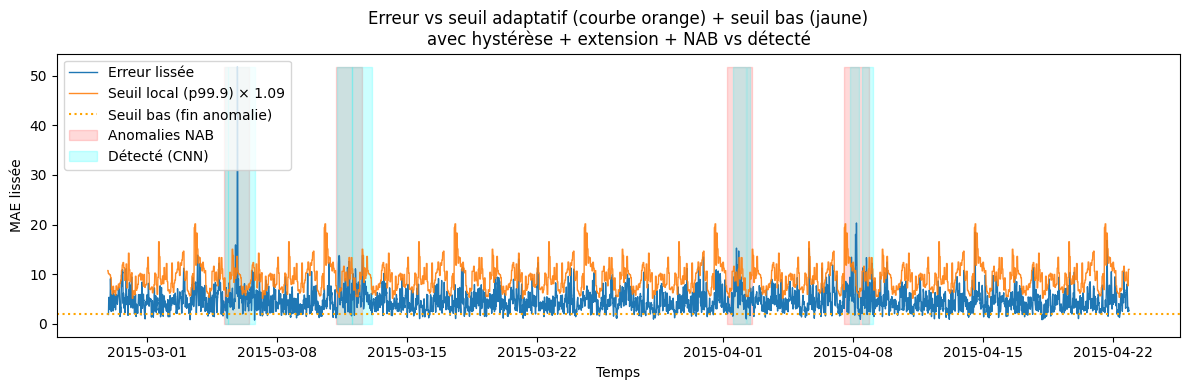

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")

plt.plot(
    df[TIME_COL],
    thr_eff,
    lw=1,
    alpha=0.9,
    label=f'Seuil local (p{int(q*1000)/10}) × {FACTOR}'
)

plt.axhline(
    y=seuil_bas,
    color="orange",
    linestyle=":",
    label="Seuil bas (fin anomalie)"
)

ymax = np.nanmax(df["err_smooth"].values)

is_anom_nab = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom_nab,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

is_detected = flags & valid_mask

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_detected,
    alpha=0.20,
    color="cyan",
    label="Détecté (CNN)"
)

plt.title("Erreur vs seuil adaptatif (courbe orange) + seuil bas (jaune)\navec hystérèse + extension + NAB vs détecté")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()